# Get Ulta locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import os
import requests
import json

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1020
pd.options.display.max_colwidth = None

---

## Scrape

#### Download directory from inline source and read locally

In [4]:
directory = gpd.read_file("data/raw/directory.json").drop(["metaCustomSlug"], axis=1)

#### Basic information

In [5]:
directory.query('branch=="1220"')

,id,name,branch,slug,geometry
50,2806983,Ulta Beauty,1220,latham-ny-1220,POINT (-73.76909 42.75726)


#### URLs for each location

In [6]:
directory["url"] = "https://www.ulta.com/stores/" + directory["slug"]

#### Loop through URLs and snag data about each location

In [8]:
directory_list = []

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"
}

for l in tqdm(directory["url"].to_list()):
    url = l
    response = requests.get(l, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    directory_dict = {
        "address": json.loads(soup.find("script", type="application/ld+json").text)[
            "address"
        ]["streetAddress"].replace(", null", ""),
        "city": json.loads(soup.find("script", type="application/ld+json").text)[
            "address"
        ]["addressLocality"],
        "zip": json.loads(soup.find("script", type="application/ld+json").text)[
            "address"
        ]["postalCode"],
        "phone": json.loads(soup.find("script", type="application/ld+json").text)[
            "telephone"
        ],
        "branch": json.loads(soup.find("script", type="application/ld+json").text)[
            "branchCode"
        ],
    }
    directory_list.append(directory_dict)

  0%|          | 0/1411 [00:00<?, ?it/s]

#### Stuff into a dataframe

In [9]:
src = pd.DataFrame(directory_list)

#### Merge the scraped location details and the directory info

In [10]:
gdf = gpd.GeoDataFrame(pd.merge(directory, src, on="branch").reset_index(drop=True))

<AxesSubplot: >

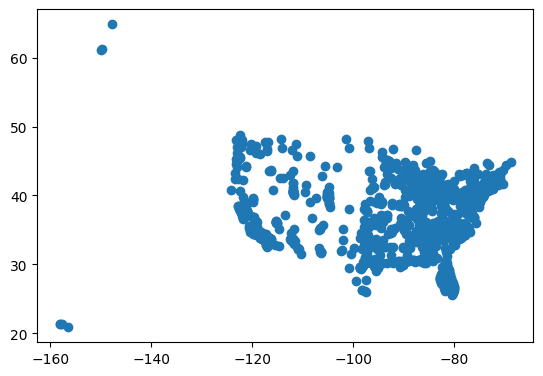

In [17]:
gdf.plot()

#### Split the state name out of the slug

In [11]:
gdf["state"] = gdf["slug"].str.split("-", expand=True)[1].str.upper()

#### Rearrange things

In [12]:
gdf = gdf[
    ["name", "branch", "address", "city", "zip", "state", "phone", "url", "geometry"]
].copy()

In [13]:
df = gdf[["name", "branch", "address", "city", "zip", "state", "phone", "url"]].copy()

---

## Exports

In [14]:
gdf.to_file("data/processed/ulta.geojson", driver="GeoJSON")

In [15]:
df.to_json("data/processed/ulta.json", orient="records", indent=4)

In [16]:
df.to_csv("data/processed/ulta.csv", index=False)